# train MLP using embeddings from different layers (GPU; total)

In [1]:
import numpy as np
import pandas as pd

In [2]:
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
from torch.utils.data import TensorDataset, random_split

# define functions

In [3]:
def try_gpu(i=2): #@save 
    """如果存在，则返回gpu(i)，否则返回cpu()""" 
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')


In [4]:
print("Number of available GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Number of available GPUs: 4
Current GPU: 0
GPU Name: NVIDIA A100-PCIE-40GB


In [5]:
from matplotlib_inline import backend_inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython import display

def use_svg_display(): #@save 
    """使用svg格式在Jupyter中显示绘图""" 
    backend_inline.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend): 
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator: #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数 
        self.config_axes = lambda: set_axes(
                self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
    def save2pdf(self, outpdf="trainLoss_trainAcc_testAcc.pdf"):
        self.fig.savefig(outpdf, transparent = True)
        

In [6]:
### using CPU

def accuracy(y_hat, y): #@save 
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter): #@save 
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数 
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
            
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater): #@save 
    """训练模型一个迭代周期(定义⻅第3章)"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数 
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):
        # 使用PyTorch内置的优化器和损失函数 
        updater.zero_grad() 
        l.mean().backward()
        updater.step()
    else:
        # 使用定制的优化器和损失函数 
        l.sum().backward() 
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel()) 
    
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save 
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [7]:
### using GPU

import time
class Timer: #@save 
    """记录多次运行时间""" 
    def __init__(self):
        self.times = []
        self.start()
    def start(self): 
        """启动计时器"""
        self.tik = time.time()
    def stop(self): 
        """停止计时器并将时间记录在列表中""" 
        self.times.append(time.time() - self.tik) 
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self): 
        """返回时间总和""" 
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()


class Accumulator: #@save 
    """在n个变量上累加""" 
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

    
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save 
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval() # 设置为评估模式 
        if not device:
            device = next(iter(net.parameters())).device 
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的(之后将介绍)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]    


def train_ch6(net, train_iter, test_iter, num_epochs, lr, device, outpdf, batch_size, embed): 
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数 
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        
    animator.save2pdf(outpdf)
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    LossAcc_dict = {}
    LossAcc_dict['train_loss'] = [train_l]
    LossAcc_dict['train_acc'] = [train_acc]
    LossAcc_dict['test_acc'] = [test_acc]
    LossAcc_dict['lr'] = [lr]
    LossAcc_dict['num_epochs'] = [num_epochs]
    LossAcc_dict['batch_size'] = [batch_size]
    LossAcc_dict['embed'] = [embed]
    
    
    return LossAcc_dict

# import data (X, y)  
add universal-complementary CHMs


In [8]:
def try_gpu(i=2): #@save 
    """如果存在，则返回gpu(i)，否则返回cpu()""" 
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')


In [9]:
sequence_df_woN = pd.read_pickle('/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/embedding_results/total_CPU/dataset_y_wiUniversalComplement.pkl')
### keep y in the same order of embedding results
sequence_df_woN_2 = sequence_df_woN.loc[sequence_df_woN['label'] == 2]
sequence_df_woN_10 = sequence_df_woN.loc[sequence_df_woN['label'] != 2]
sequence_df_woN_210 = pd.concat([sequence_df_woN_2, sequence_df_woN_10])

y_total = torch.tensor(sequence_df_woN_210['label'].tolist())


# Set the random seed
seed = 123
torch.manual_seed(seed)

# Define the number of elements to select
num_elements = sequence_df_woN.shape[0] * .2

# Create a random index tensor
rand_idx = torch.randperm(sequence_df_woN.shape[0])


In [10]:
run = False
if run :
    for embed in range(10, 21) :
        for i in range(0, 25464, 100) :
            np_100 = np.load(f'/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/embedding_results/total_CPU/seqStartLine{i}_mean_embeddings_{embed}.npy')
            if i == 0 :
                mean_embeddings = np_100
            else :
                mean_embeddings = np.concatenate((mean_embeddings, np_100))

        np.save(f'/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/embedding_results/total_CPU/seqStartLineTotal_mean_embeddings_{embed}.npy',
               mean_embeddings)
    

In [11]:
run = False
if run :
    for embed in range(10, 21) :
        for i in range(0, 2392, 100) :
            np_100 = np.load(f'/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/embedding_results/total_CPU/seqStartLine{i}_mean_embeddings_{embed}_universalComplement.npy')
            if i == 0 :
                mean_embeddings = np_100
            else :
                mean_embeddings = np.concatenate((mean_embeddings, np_100))

        np_uniCHM_nonCHM = np.load(f'/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/embedding_results/total_CPU/seqStartLineTotal_mean_embeddings_{embed}.npy')
        mean_embeddings = np.concatenate((mean_embeddings, np_uniCHM_nonCHM))
        np.save(f'/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/embedding_results/total_CPU/seqStartLineTotal_mean_embeddings_{embed}_UniCHM1UniComp2nonCHM0.npy',
               mean_embeddings)
    

In [12]:
def dataset_X_prepare(embed) :
    mean_embeddings = np.load(f'/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/embedding_results/total_CPU/seqStartLineTotal_mean_embeddings_{embed}_UniCHM1UniComp2nonCHM0.npy')
    
    num_elements = int(sequence_df_woN.shape[0] * .8)
    dataset_idx = rand_idx[:num_elements]
    realTest_idx = rand_idx[num_elements:]
    
    dataset_X_total = torch.from_numpy(mean_embeddings)
    dataset_X = dataset_X_total[dataset_idx]
    dataset_X_realTest = dataset_X_total[realTest_idx]
    
    y_realTest = y_total[realTest_idx]
    y = y_total[dataset_idx]
    
    dataset = TensorDataset(dataset_X, y)
    dataset_realTest = TensorDataset(dataset_X_realTest, y_realTest)
    
    return (dataset, dataset_realTest)


In [13]:
def get_dataloader_workers(): #@save 
    """使用4个进程来读取数据""" 
    return 4

def dataset_iter_prepare(embed = 20, cuda = 2, batch_size = 5) :
    dataset, dataset_realTest = dataset_X_prepare(embed)
    
    train_len = int(0.8 * len(dataset))
    test_len = len(dataset) - train_len

    train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

    train_iter = data.DataLoader(train_dataset, batch_size, shuffle=True,
                                 num_workers=get_dataloader_workers())
    test_iter = data.DataLoader(test_dataset, batch_size, shuffle=True,
                                 num_workers=get_dataloader_workers())
    return (train_iter, test_iter, dataset_realTest)

# train Model

In [14]:
### init a MLP
def init_MLP(cuda=2) :
    net = nn.Sequential(nn.Flatten(),
                        nn.Linear(2560, 512),
                        nn.ReLU(),
                        nn.Linear(512, 3)) ###
    net = net.to(device=try_gpu(cuda))

    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)

    net.apply(init_weights)
    return net

In [15]:
### using CPU

# batch_size, lr, num_epochs = 5, 0.4, 2
# loss = nn.CrossEntropyLoss(reduction='none').to(try_gpu(2))
# trainer = torch.optim.SGD(net.parameters(), lr=lr)
# train_ch3(net, train_iter, test_iter, loss, batch_size, trainer)

In [16]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

`CUDA_LAUNCH_BLOCKING` is an environment variable used to control the asynchronous behavior of CUDA kernel launches. By default, CUDA kernel launches are asynchronous, which means that the CPU can continue executing other tasks while the GPU is processing the kernel.

The `CUDA_LAUNCH_BLOCKING` environment variable can be set to control this behavior:  

`0` (default): CUDA kernel launches are asynchronous. The CPU will not wait for the GPU to finish executing the kernel before proceeding to the next task.  
`1`: CUDA kernel launches are synchronous. The CPU will **wait for the GPU to finish executing the kernel before proceeding to the next task**. This can be useful for debugging purposes, as it makes it easier to identify the source of errors and makes error messages more accurate.


In [17]:
def train_MLP(embed = 20, cuda = 2, batch_size = 50, num_epochs = 100, lr = 0.0001, 
              outpdf = 'make2_MLP_trainLossAcc_testAcc_embed20.pdf',
              outmodel = f"MLP_embed20_bs50_epc100_lr1e-5.pt"
             ) :
    print(f'embed = {embed}, cuda = {cuda}, batch_size = {batch_size}, num_epochs = {num_epochs}, lr = {lr}')
    net = init_MLP(cuda)
    train_iter, test_iter, dataset_realTest = dataset_iter_prepare(embed, cuda, batch_size)
    LossAcc_dict = train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu(cuda), outpdf, batch_size, embed)
    torch.save(net.state_dict(), outmodel)
    return (LossAcc_dict, dataset_realTest)


In [19]:
train_flag = False
if train_flag :
    dataset_realTest_ls = []
    LossAcc_df = pd.DataFrame()
    for embed in range(10, 21, 5) :
        for batch_size in [50, 100, 500] :
            for num_epochs in [10, 50, 100] :
                for lr in [0.001, 0.0001, 0.00001] :
                    LossAcc_dict, dataset_realTest = train_MLP(
                        embed = embed, cuda = 2, batch_size = batch_size, num_epochs = num_epochs, lr = lr,
                        outpdf = f'/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/figures/make2_MLP_trainLossAcc_testAcc_embed{embed}_bs{batch_size}_epc{num_epochs}_lr{lr:.0e}_UniCHM1UniComp2nonCHM0.pdf',
                        outmodel = f"/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/model_save_MLP_with_diff_hyperParas/MLP_embed{embed}_bs{batch_size}_epc{num_epochs}_lr{lr:.0e}_UniCHM1UniComp2nonCHM0.pt")
                    df = pd.DataFrame.from_dict(LossAcc_dict)
                    LossAcc_df = pd.concat([LossAcc_df, df])
                    print(LossAcc_dict)
                    dataset_realTest_ls.append(dataset_realTest)
    
# LossAcc_df

因为固定了seed，每次返回的dataset_realTest都是一样的：

In [33]:
dataset_realTest_ls[0][0]

(tensor([ 2.8265e-01, -5.9396e-01, -8.5485e-04,  ...,  4.8624e-02,
          3.9713e-01,  9.9977e-01]),
 tensor(0))

In [34]:
dataset_realTest_ls[1][0]

(tensor([ 2.8265e-01, -5.9396e-01, -8.5485e-04,  ...,  4.8624e-02,
          3.9713e-01,  9.9977e-01]),
 tensor(0))

In [35]:
LossAcc_df.to_csv(
    '/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/model_save_MLP_with_diff_hyperParas/MLP_lossAcc_df_UniCHM1UniComp2nonCHM0.csv',
    index = False
                 )

In [36]:
LossAcc_df.loc[LossAcc_df['test_acc'] == LossAcc_df['test_acc'].max()]

,train_loss,train_acc,test_acc,lr,num_epochs,batch_size,embed
0,0.091317,0.967689,0.967691,0.001,100,50,15


# accuracy of test dataset

In [20]:
train_flag = False
if train_flag == False :
    LossAcc_df = pd.read_csv(
        '/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/model_save_MLP_with_diff_hyperParas/MLP_lossAcc_df_UniCHM1UniComp2nonCHM0.csv',
)
LossAcc_df

,train_loss,train_acc,test_acc,lr,num_epochs,batch_size,embed
0,0.146165,0.950468,0.950191,0.00100,10,50,10
1,0.180255,0.943905,0.944806,0.00010,10,50,10
2,0.295866,0.915185,0.923716,0.00001,10,50,10
3,0.114801,0.959556,0.951761,0.00100,50,50,10
4,0.135371,0.954115,0.956249,0.00010,50,50,10
...,...,...,...,...,...,...,...
76,0.148769,0.948449,0.936056,0.00010,50,500,20
77,0.241724,0.928591,0.927754,0.00001,50,500,20
78,0.107719,0.963146,0.954005,0.00100,100,500,20
79,0.135876,0.954507,0.947723,0.00010,100,500,20


In [23]:
realTestAcc_ls = []
for embed in range(10, 21, 5) :
    _, dataset_realTest = dataset_X_prepare(embed)
    for batch_size in [50, 100, 500] :
        for num_epochs in [10, 50, 100] :
            for lr in [0.001, 0.0001, 0.00001] :
                
                ### load state_dict of model
                net_state_dict = torch.load(f"/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/model_save_MLP_with_diff_hyperParas/MLP_embed{embed}_bs{batch_size}_epc{num_epochs}_lr{lr:.0e}_UniCHM1UniComp2nonCHM0.pt")
                net_forTest = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2560, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 3))
                net_forTest.load_state_dict(net_state_dict)
                net_forTest = net_forTest.to(device=try_gpu(2))
       
                ### iter realTest dataset
                realTest_iter = data.DataLoader(dataset_realTest, batch_size, shuffle=True,
                                 num_workers=get_dataloader_workers())
                realTestAcc = evaluate_accuracy_gpu(net_forTest, realTest_iter, 2)
                realTestAcc_ls.append(realTestAcc)
                print(f'embed: {embed}, bs: {batch_size}, epc: {num_epochs}, lr: {lr}, realTestAcc: {realTestAcc}')
                
                
LossAcc_df_final = LossAcc_df.copy()
LossAcc_df_final['realTest_acc'] = realTestAcc_ls
LossAcc_df_final

embed: 10, bs: 50, epc: 10, lr: 0.001, realTestAcc: 0.9452620244077531
embed: 10, bs: 50, epc: 10, lr: 0.0001, realTestAcc: 0.9411342426417804
embed: 10, bs: 50, epc: 10, lr: 1e-05, realTestAcc: 0.9187006460875807
embed: 10, bs: 50, epc: 50, lr: 0.001, realTestAcc: 0.955491744436468
embed: 10, bs: 50, epc: 50, lr: 0.0001, realTestAcc: 0.950646087580761
embed: 10, bs: 50, epc: 50, lr: 1e-05, realTestAcc: 0.9386216798277099
embed: 10, bs: 50, epc: 100, lr: 0.001, realTestAcc: 0.9014716439339555
embed: 10, bs: 50, epc: 100, lr: 0.0001, realTestAcc: 0.9544149318018664
embed: 10, bs: 50, epc: 100, lr: 1e-05, realTestAcc: 0.9411342426417804
embed: 10, bs: 100, epc: 10, lr: 0.001, realTestAcc: 0.9296482412060302
embed: 10, bs: 100, epc: 10, lr: 0.0001, realTestAcc: 0.9362885857860732
embed: 10, bs: 100, epc: 10, lr: 1e-05, realTestAcc: 0.8932160804020101
embed: 10, bs: 100, epc: 50, lr: 0.001, realTestAcc: 0.9269562096195262
embed: 10, bs: 100, epc: 50, lr: 0.0001, realTestAcc: 0.947056712132

,train_loss,train_acc,test_acc,lr,num_epochs,batch_size,embed,realTest_acc
0,0.146165,0.950468,0.950191,0.00100,10,50,10,0.945262
1,0.180255,0.943905,0.944806,0.00010,10,50,10,0.941134
2,0.295866,0.915185,0.923716,0.00001,10,50,10,0.918701
3,0.114801,0.959556,0.951761,0.00100,50,50,10,0.955492
4,0.135371,0.954115,0.956249,0.00010,50,50,10,0.950646
...,...,...,...,...,...,...,...,...
76,0.148769,0.948449,0.936056,0.00010,50,500,20,0.942570
77,0.241724,0.928591,0.927754,0.00001,50,500,20,0.928751
78,0.107719,0.963146,0.954005,0.00100,100,500,20,0.951902
79,0.135876,0.954507,0.947723,0.00010,100,500,20,0.952800


In [24]:
LossAcc_df_final.loc[LossAcc_df_final['test_acc'] == LossAcc_df_final['test_acc'].max()]

,train_loss,train_acc,test_acc,lr,num_epochs,batch_size,embed,realTest_acc
33,0.091317,0.967689,0.967691,0.001,100,50,15,0.959799


In [25]:
LossAcc_df_final.loc[LossAcc_df_final['realTest_acc'] == LossAcc_df_final['realTest_acc'].max()]

,train_loss,train_acc,test_acc,lr,num_epochs,batch_size,embed,realTest_acc
60,0.08286,0.971897,0.964101,0.001,100,50,20,0.961594


In [26]:
LossAcc_df_final.sort_values(['realTest_acc'], ascending = False)

,train_loss,train_acc,test_acc,lr,num_epochs,batch_size,embed,realTest_acc
60,0.082860,0.971897,0.964101,0.00100,100,50,20,0.961594
69,0.090729,0.969092,0.960063,0.00100,100,100,20,0.960158
33,0.091317,0.967689,0.967691,0.00100,100,50,15,0.959799
57,0.095604,0.967297,0.960512,0.00100,50,50,20,0.958543
58,0.114804,0.960846,0.956473,0.00010,50,50,20,0.958363
...,...,...,...,...,...,...,...,...
74,0.379241,0.897627,0.904196,0.00001,10,500,20,0.895908
11,0.336077,0.890615,0.902849,0.00001,10,100,10,0.893216
23,0.343616,0.866607,0.857303,0.00001,50,500,10,0.865578
47,0.488533,0.863634,0.864258,0.00001,10,500,15,0.863783


# precision accuracy plot

In [21]:
### load model of hyperparameters with best performance

num_epochs = 100
lr = 0.001
batch_size = 50
embed = 20

net_state_dict_best = torch.load(f"/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/model_save_MLP_with_diff_hyperParas/MLP_embed{embed}_bs{batch_size}_epc{num_epochs}_lr{lr:.0e}_UniCHM1UniComp2nonCHM0.pt")
net_best = nn.Sequential(nn.Flatten(),
                            nn.Linear(2560, 512),
                            nn.ReLU(),
                            nn.Linear(512, 3))
net_best.load_state_dict(net_state_dict_best)
# net_best = net_best.to(device=try_gpu(2))


### prepare test dataset
_, dataset_realTest = dataset_X_prepare(embed)
realTest_iter = data.DataLoader(dataset_realTest, batch_size, shuffle=True,
                 num_workers=get_dataloader_workers())

print(f'embed: {embed}, bs: {batch_size}, epc: {num_epochs}, lr: {lr}')

embed: 20, bs: 50, epc: 100, lr: 0.001


# ROC

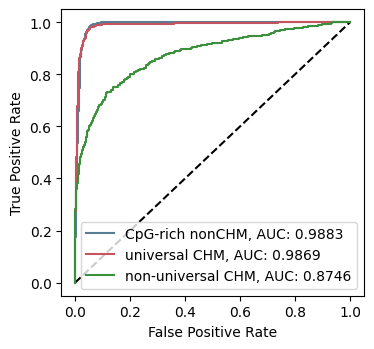

In [45]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming you have a PyTorch model "model" and a test loader "test_loader"
# And n_classes is the number of classes in your dataset

net_best.eval()
y_test = []
y_score = []

with torch.no_grad():
    for dataset, target in realTest_iter:
#         output = torch.softmax(net_best(dataset), dim=1)  # get probabilities for each class
        output = net_best(dataset) # get probabilities for each class
        y_score.extend(output.numpy().tolist())
        y_test.extend(target.numpy().tolist())

# Binarize the output
y_test = label_binarize(y_test, classes=[*range(3)])
y_score = np.array(y_score)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
fig, ax = plt.subplots(figsize = (6.4 * .6, 4.8 * .75), tight_layout = True)
ax.plot([0, 1], [0, 1], 'k--')
color_ls = ['#597d92', '#c7535e', '#3b913b']
class_dict = {1: 'universal CHM', 2: 'non-universal CHM', 0: 'CpG-rich nonCHM'}
for i in range(3):
    ax.plot(fpr[i], tpr[i], label=f'{class_dict[i]}, AUC: %0.4f' % roc_auc[i], color = color_ls[i])
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
#     ax.set_title('ROC for class {}'.format(i))
    ax.legend(loc="lower right")
    fig.savefig(
        f'/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/figures/make2_3_ROC_UniCHM1UniComp2nonCHM0_merged.pdf',
        transparent = True
            )

    

## precision-recall curve

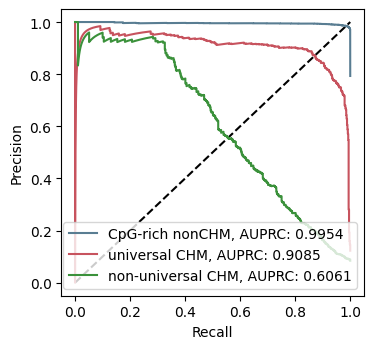

In [44]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

# Assuming you have a PyTorch model "model" and a test loader "test_loader"
# And n_classes is the number of classes in your dataset

net_best.eval()
y_test = []
y_score = []

with torch.no_grad():
    for dataset, target in realTest_iter:
        output = net_best(dataset)  # get probabilities for each class
        y_score.extend(output.numpy().tolist())
        y_test.extend(target.numpy().tolist())

# Binarize the output
y_test = label_binarize(y_test, classes=[*range(3)])
y_score = np.array(y_score)

# Compute precision and recall for each class
p_dict = {}
r_dict = {}
AUPRC_dict = {}
for i in range(3):  
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    p_dict[i] = precision
    r_dict[i] = recall
    avg_precision = average_precision_score(y_test[:, i], y_score[:, i])
    AUPRC_dict[i] = avg_precision


# Plot the ROC curve for each class
fig, ax = plt.subplots(figsize = (6.4 * .6, 4.8 * .75), tight_layout = True)
ax.plot([0, 1], [0, 1], 'k--')
color_ls = ['#597d92', '#c7535e', '#3b913b']
class_dict = {1: 'universal CHM', 2: 'non-universal CHM', 0: 'CpG-rich nonCHM'}
for i in range(3):
    ax.plot(r_dict[i], p_dict[i], label=f'{class_dict[i]}, AUPRC: %0.4f' % AUPRC_dict[i], color = color_ls[i])
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
#     ax.set_title('ROC for class {}'.format(i))
    ax.legend(loc="lower right")
    fig.savefig(
        f'/mnt/Storage/home/wangyiman/NLP_model/universalCHM_prediction_with_NLP_model/use_nucleotide_transformer/figures/make2_3_PRC_UniCHM1UniComp2nonCHM0_merged.pdf',
        transparent = True
            )

    